In [166]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD

torch.manual_seed(42)

import os

DATA_DIR_PATH = os.getcwd() + "/data/"

BATCH_SIZE = 32
LEARNING_RATE = 0.009
NUM_EPOCHS = 15

In [240]:
class FashionMNIST(Dataset):

    def __init__(self, file_path, transform=None):
        self._df = pd.read_csv(file_path)
        self.labels = self._df.label.values
        self.images = self._df.iloc[:, 1:].values.astype(np.uint8).reshape((-1, 28, 28)) # reshape from 1d vec
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [241]:
transform = ToTensor()
train_dataset = FashionMNIST(DATA_DIR_PATH + "fashion-mnist_train.csv", transform)
test_dataset = FashionMNIST(DATA_DIR_PATH + "fashion-mnist_test.csv", transform)

In [242]:
train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=4)

In [170]:
class LeNet5(nn.Module):

    def __init__(self):
        super(LeNet5, self).__init__()
        self.convolution_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5, 5), padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
        )
        self.fully_connected_layer = nn.Sequential(
            nn.Flatten(), # [64, 16, 5, 5] -> 1d tensor
            nn.Linear(5*5*16, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            # nn.Dropout(.3),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.convolution_layer(x)
        out = self.fully_connected_layer(x)
        return out

LeNet5()

LeNet5(
  (convolution_layer): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_connected_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=400, out_features=120, bias=True)
    (2): ReLU()
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): ReLU()
    (5): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [171]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [172]:
@torch.no_grad()
def accuracy(output, labels):
    pred = torch.argmax(output, dim=1)
    correct = pred.eq(labels)
    return torch.sum(correct.int()) / len(labels)

In [173]:
def train_loop(model, data, loss_func, opt):
    total_loss = .0
    for images, labels in data:
        images, labels = images.to(device), labels.to(device)
        out = model(images)

        opt.zero_grad()
        loss = loss_func(out, labels)
        loss.backward()
        opt.step()

        total_loss += loss.item()
    return total_loss / len(data)

In [174]:
def test_loop(model, data, loss_func):
    total_loss, acc = .0, .0
    for images, labels in data:
        with torch.no_grad():
            images, labels = images.to(device), labels.to(device)
            out = model(images)
            loss = loss_func(out, labels)
            total_loss += loss.item()
            acc += accuracy(out, labels)
    return total_loss / len(data), acc.cpu() / len(data) * 100

In [175]:
model = LeNet5().to(device)
loss_func = nn.CrossEntropyLoss()
opt = SGD(model.parameters(), lr=LEARNING_RATE)

In [176]:
train_losses = []
test_losses = []
accuracies = []

for epoch in range(NUM_EPOCHS):

    model.train()
    loss = train_loop(model, train, loss_func, opt)
    train_losses.append(loss)

    model.eval()
    loss, acc = test_loop(model, test, loss_func)
    test_losses.append(loss)
    accuracies.append(acc)

    print (f'[Epoch {epoch + 1}/{NUM_EPOCHS}] Train loss: {train_losses[-1]}, Test loss: {test_losses[-1]}')

[Epoch 1/15] Train loss: 1.4262092156569164, Test loss: 0.7341573285028196
[Epoch 2/15] Train loss: 0.6696882769584656, Test loss: 0.5909543035510249
[Epoch 3/15] Train loss: 0.555681429831187, Test loss: 0.5283941994079004
[Epoch 4/15] Train loss: 0.4854619777679443, Test loss: 0.4404614636311516
[Epoch 5/15] Train loss: 0.44204257598320645, Test loss: 0.4201532177888928
[Epoch 6/15] Train loss: 0.41087465210358304, Test loss: 0.40229952444855016
[Epoch 7/15] Train loss: 0.38867937342723213, Test loss: 0.38484227716827546
[Epoch 8/15] Train loss: 0.3703373413880666, Test loss: 0.37699179905957686
[Epoch 9/15] Train loss: 0.35365140776435533, Test loss: 0.34093140572690356
[Epoch 10/15] Train loss: 0.3420342596014341, Test loss: 0.3350151809402548
[Epoch 11/15] Train loss: 0.33065869609912235, Test loss: 0.3412383139466706
[Epoch 12/15] Train loss: 0.3207234490374724, Test loss: 0.3226216363783081
[Epoch 13/15] Train loss: 0.31152929507692656, Test loss: 0.31676127414067334
[Epoch 14/1

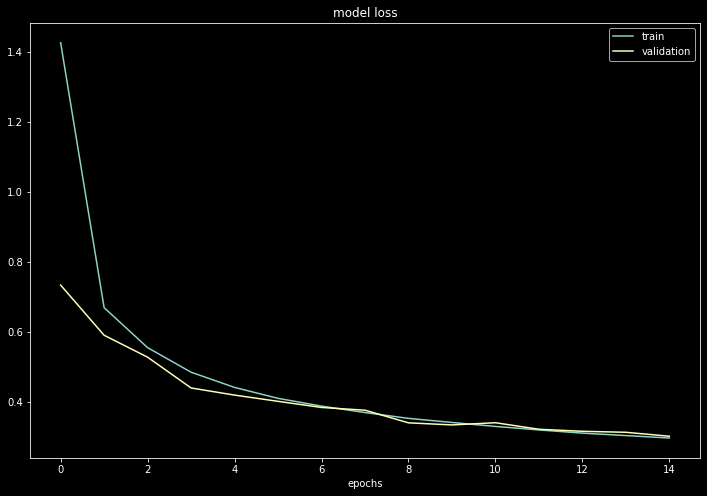

In [177]:
import matplotlib.pyplot as plt

def plot(train, test, title):
    plt.figure(figsize=(12, 8))
    plt.plot(train)
    plt.plot(test)
    plt.legend(["train", "validation"])
    plt.title(f"model {title}")
    plt.xlabel("epochs")
    plt.show()

plot(train_losses, test_losses, "loss")

In [178]:
print(f"Accuracy of the test data: {accuracies[-1]} %")

Accuracy of the test data: 89.01757049560547 %


In [179]:
test_iter = iter(test)
images, labels = next(test_iter)

with torch.no_grad():
    images, labels = images.to(device), labels.to(device)
    pred = model(images)

In [180]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
images_ = [img.numpy() for img in images.cpu()]

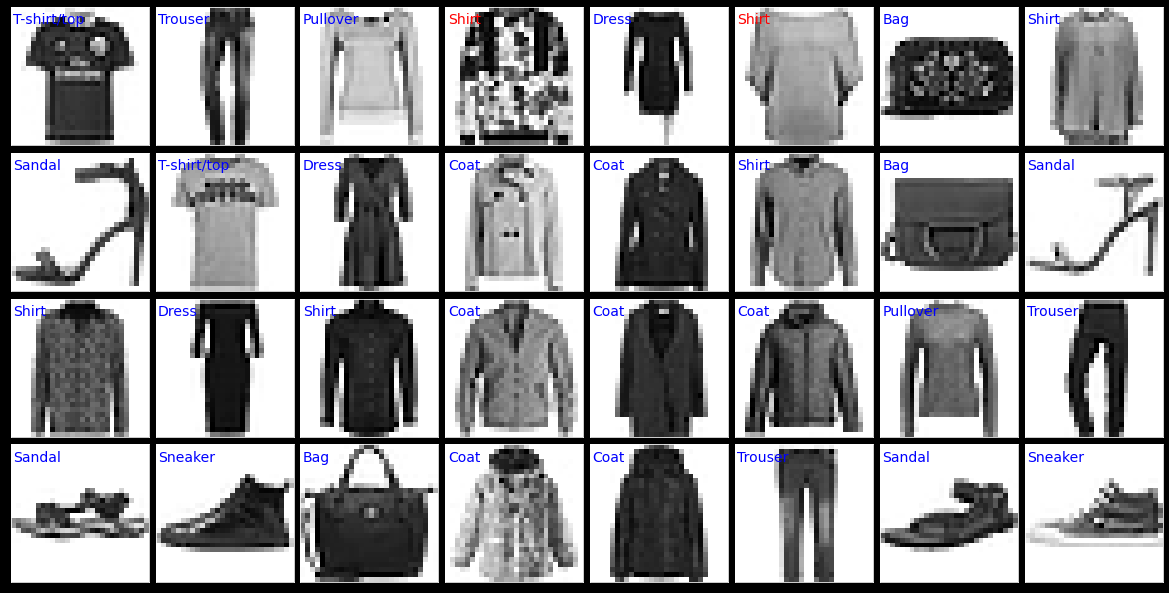

In [181]:
plt.style.use('dark_background')
fig = plt.figure(figsize=(16, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i, img in enumerate(images_):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(img.reshape(28, 28, 1), cmap=plt.cm.gray_r)

    color = "blue" if pred[i].argmax().item() == labels[i].item() else "red"
    ax.text(0, 3, class_names[pred[i].argmax().item()], color=color, fontsize=14)

In [182]:
class PairDataset(FashionMNIST):

    def __init__(self, file_path, transform):
        super(PairDataset, self).__init__(file_path, transform)
        self._label_classes = np.unique(self.labels)
        self._image_groups = []

        for label in self._label_classes:
            self._image_groups.append(self.images[np.where(self.labels == label)[0]])
        self._groups_size = [group.shape[0] for group in self._image_groups]

    def __getitem__(self, item):
        group_idx = np.random.choice(self._label_classes, 1)[0] # random choose image group by label
        img1 = self._get_image(group_idx)

        is_positive = np.random.rand() >= 0.5 # approx 50% of images are in the same class
        if is_positive:
            img2 = self._get_image(group_idx)
        else:
            group_idx = np.random.choice([i for i in self._label_classes if i != group_idx]) # choose other group
            img2 = self._get_image(group_idx)

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.from_numpy(np.array(int(is_positive >= .5)))

    def _get_image(self, group_idx): # get random image by group
        img_idx = np.random.choice(self._groups_size[group_idx], 1)[0]
        return self._image_groups[group_idx][img_idx, :, :]

In [183]:
transform = ToTensor()
train_dataset = PairDataset(DATA_DIR_PATH + "fashion-mnist_train.csv", transform)
test_dataset = PairDataset(DATA_DIR_PATH + "fashion-mnist_test.csv", transform)

In [207]:
train = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)

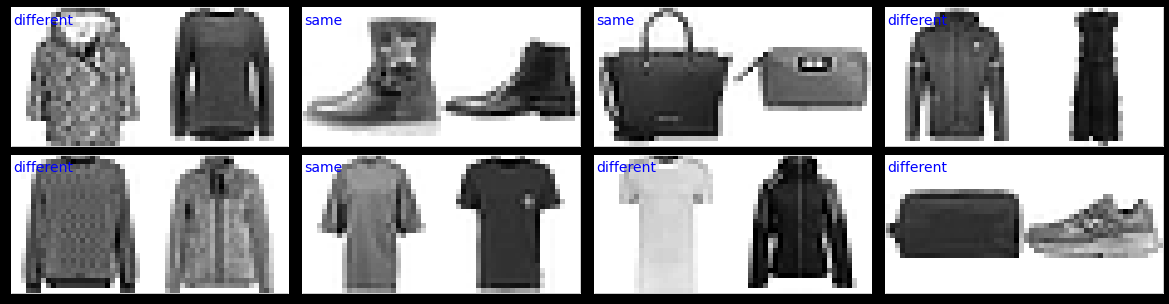

In [208]:
test_iter = iter(train)
imgs1, imgs2, labels = next(test_iter)
plt.style.use('dark_background')
fig = plt.figure(figsize=(16, 4))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i, (img1, img2, label) in enumerate(zip(imgs1[:8], imgs2[:8], labels[:8])):
    img = np.concatenate((img1.numpy()[0], img2.numpy()[0]), axis=1)
    ax = fig.add_subplot(2, 4, i+1, xticks=[], yticks=[])
    ax.text(0, 3, f"{'same' if label == 1 else 'different'}", fontsize=14, color="blue")
    ax.imshow(img, cmap=plt.cm.gray_r)

In [186]:
class SiameseNet(nn.Module):

    def __init__(self):
        super(SiameseNet, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(20, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),

            nn.Linear(16, 4),
            nn.BatchNorm1d(4),
            nn.ReLU(),

            nn.Linear(4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layer(x)

SiameseNet()

SiameseNet(
  (layer): Sequential(
    (0): Linear(in_features=20, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=4, bias=True)
    (4): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=4, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [187]:
def train_loop(siamese, data, loss_func, opt):
    total_loss = .0

    for img1, img2, labels in data:
        img1, img2 = img1.to(device), img2.to(device)
        labels = labels.reshape(-1, 1).to(device)

        with torch.no_grad():
            out1, out2 = model(img1), model(img2)
        combined = torch.cat((out1, out2), 1)
        out = siamese(combined)

        opt.zero_grad()
        loss = loss_func(out, labels.to(torch.float32))
        loss.backward()
        opt.step()

        total_loss += loss.item()
    return total_loss / len(data)

In [188]:
def test_loop(siamese, data, loss_func):
    total_loss = .0
    for img1, img2, labels in data:
        with torch.no_grad():
            img1, img2 = img1.to(device), img2.to(device)
            labels = labels.reshape(-1, 1).to(device)

            out1, out2 = model(img1), model(img2)
            combined = torch.cat((out1, out2), 1)
            out = siamese(combined)
            loss = loss_func(out, labels.to(torch.float32))
            total_loss += loss.item()

    return total_loss / len(data)

In [189]:
BATCH_SIZE = 64
LEARNING_RATE = 0.03
NUM_EPOCHS = 10

siamese = SiameseNet().to(device)
loss_func = nn.BCELoss()
opt = SGD(siamese.parameters(), lr=LEARNING_RATE)

train_losses = []
test_losses = []

for epoch in range(NUM_EPOCHS):

    siamese.train()
    loss = train_loop(siamese, train, loss_func, opt)
    train_losses.append(loss)

    siamese.eval()
    loss = test_loop(siamese, train, loss_func)
    test_losses.append(loss)


    print(f'[Epoch {epoch + 1}/{NUM_EPOCHS}] Train loss: {train_losses[-1]}, Test loss: {test_losses[-1]}')

[Epoch 1/10] Train loss: 0.35944705406427385, Test loss: 0.2534041454354922
[Epoch 2/10] Train loss: 0.27630676767031354, Test loss: 0.2255251400868098
[Epoch 3/10] Train loss: 0.25973233713905014, Test loss: 0.21852781555056572
[Epoch 4/10] Train loss: 0.25495264810323714, Test loss: 0.21664149503906568
[Epoch 5/10] Train loss: 0.2448360620657603, Test loss: 0.22030221702257793
[Epoch 6/10] Train loss: 0.24395178465048473, Test loss: 0.20461515326301258
[Epoch 7/10] Train loss: 0.24147920527458192, Test loss: 0.2030798071185748
[Epoch 8/10] Train loss: 0.23656920135418574, Test loss: 0.20621780286729335
[Epoch 9/10] Train loss: 0.23725443899234136, Test loss: 0.21806409114400546
[Epoch 10/10] Train loss: 0.23498306200901667, Test loss: 0.20052830522259077


In [190]:
# plot(train_losses, test_losses, "train")

In [209]:
imgs1, imgs2 = imgs1.to(device), imgs2.to(device)
# labels = labels.reshape(-1, 1).to(device)
with torch.no_grad():
    out1, out2 = model(imgs1), model(imgs2)
    combined = torch.cat((out1, out2), 1)
    out = siamese(combined)

# for prob, label in zip(out.cpu(), labels.cpu()):
#     print(f"{prob[0] * 100}%", label)

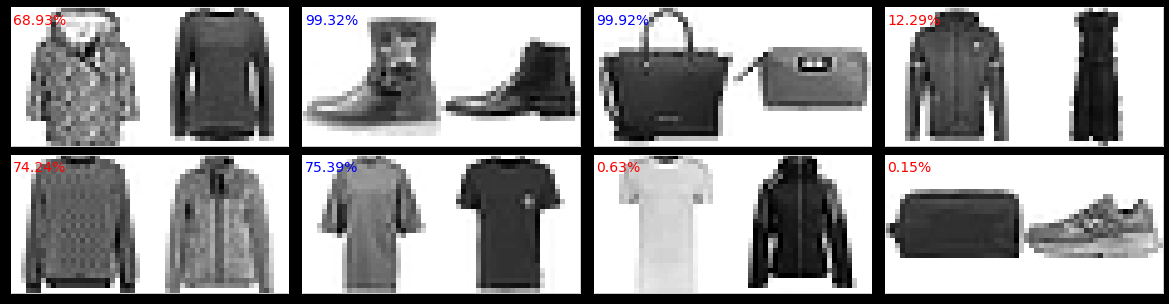

In [210]:
np.array(labels, dtype=float)
plt.style.use('dark_background')
fig = plt.figure(figsize=(16, 4))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i, (img1, img2, label) in enumerate(zip(imgs1[:8], imgs2[:8], labels[:8])):
    img = np.concatenate((img1.numpy()[0], img2.numpy()[0]), axis=1)
    ax = fig.add_subplot(2, 4, i + 1, xticks=[], yticks=[])
    ax.text(0, 3, f"{round(out.cpu().numpy()[i, 0] * 100, 2)}%", fontsize=14, color=f"{'blue' if label == 1 else 'red'}")
    ax.imshow(img, cmap=plt.cm.gray_r)

In [254]:
# test_features = pred.cpu().numpy()
test_features = None
tf_classes = None
for images, labels in test:
    with torch.no_grad():
        images = images.to(device)
        out = model(images)

        if not isinstance(test_features, np.ndarray):
            test_features = out.cpu().numpy()
            tf_classes = labels.numpy()
        else:
            test_features = np.append(test_features, out.cpu().numpy(), axis=0)
            tf_classes = np.append(tf_classes, labels.numpy(), axis=0)
test_features.shape, tf_classes.shape

((10000, 10), (10000,))

In [255]:
from sklearn.manifold import TSNE

tsne_obj = TSNE(
    n_components=2,
    init='pca',
    random_state=42,
    method='barnes_hut',
    n_iter=500,
    verbose=2
)
tsne_features = tsne_obj.fit_transform(test_features)


/home/hodackin/imgp/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.012s...
[t-SNE] Computed neighbors for 10000 samples in 0.492s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.343934
[t-SNE] Computed conditional probabilities in 0.278s


/home/hodackin/imgp/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Iteration 50: error = 70.5765457, gradient norm = 0.0045866 (50 iterations in 1.787s)
[t-SNE] Iteration 100: error = 72.1491699, gradient norm = 0.0025098 (50 iterations in 1.705s)
[t-SNE] Iteration 150: error = 73.1395264, gradient norm = 0.0016315 (50 iterations in 2.293s)
[t-SNE] Iteration 200: error = 72.5496979, gradient norm = 0.0007955 (50 iterations in 1.310s)
[t-SNE] Iteration 250: error = 72.4675064, gradient norm = 0.0004840 (50 iterations in 1.783s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.467506
[t-SNE] Iteration 300: error = 2.2570043, gradient norm = 0.0010101 (50 iterations in 1.471s)
[t-SNE] Iteration 350: error = 1.9892828, gradient norm = 0.0004674 (50 iterations in 1.897s)
[t-SNE] Iteration 400: error = 1.8378757, gradient norm = 0.0003154 (50 iterations in 1.688s)
[t-SNE] Iteration 450: error = 1.7248468, gradient norm = 0.0002286 (50 iterations in 2.314s)
[t-SNE] Iteration 500: error = 1.6404606, gradient norm = 0.0001756 (50 

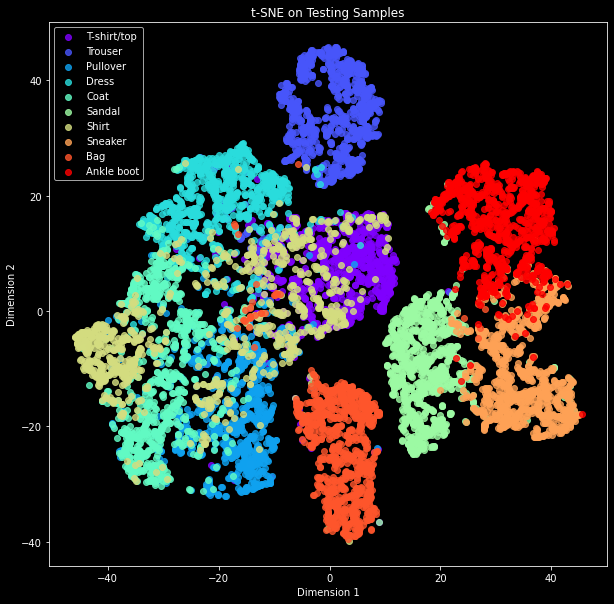

In [271]:
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, class_names)):
    plt.scatter(
        tsne_features[np.where(tf_classes == c_group), 0],
        tsne_features[np.where(tf_classes == c_group), 1],
        marker='o',
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label
    )
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
# plt.savefig('clothes-dist.png')
plt.show()

